In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-12-27 09:07:08.444186: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  0


In [2]:
data = pd.read_csv('../Data/3.normalized_dataset_image.csv')
data

,image_path,product_category_tree,label
0,aa68675f50a0551b8dadb954017a50a1.jpg,Kitchen & Dining,5
1,037c2402fee39fbc80433935711d1383.jpg,Home Furnishing,4
2,42643c1c9403f67921a18654bcf45ead.jpg,Baby Care,0
3,53f4bc7d7321f5c41de6b86e41f13e80.jpg,Home Decor & Festive Needs,3
4,b144a363c107c7bdd91f32d6e28ba6f2.jpg,Watches,6
...,...,...,...
1045,4e5ebfc871992e7e22365c0c036a1b89.jpg,Baby Care,0
1046,82fbc93cd45ab747e7e606f2c52c7335.jpg,Home Decor & Festive Needs,3
1047,216c6c3527984be3d7ad9023d5cd9bd1.jpg,Home Decor & Festive Needs,3
1048,f54d0c5cbd8e2270742293edf9075cb1.jpg,Home Furnishing,4


In [4]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
images_features = []
path = '../Data/Flipkart/Images/'
i=0 
for image_file in data["image_path"] :
    if i%100 == 0 : print(i)
    i +=1

    image = load_img(path+image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0
100
200


/Applications/anaconda3/envs/Projet6Env/lib/python3.10/site-packages/PIL/Image.py:3182: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


300
400
500
600
700
800
900
1000


(1050, 4096)

In [6]:
from sklearn import manifold, decomposition

print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)

(1050, 4096)
(1050, 803)


In [9]:
from sklearn import manifold, decomposition
import time

temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["product_category_tree"]
df_tsne['cluster'] = data['label'].copy()

temps de T-SNE :             5.65 secondes


In [10]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, n_init=100)
df_tsne['cluster_predict'] = cls.fit_predict(X_tsne)

In [11]:
def determine_cluster():
    for i in range(7):
        print(f"Valeurs les plus fréquentes pour le cluster prédit {i}")
        print(df_tsne[df_tsne['cluster_predict'] == i]['cluster'].value_counts())
determine_cluster()

Valeurs les plus fréquentes pour le cluster prédit 0
cluster
0    110
4     76
3      8
1      5
2      1
Name: count, dtype: int64
Valeurs les plus fréquentes pour le cluster prédit 1
cluster
2    106
5     37
6     11
3      6
1      5
0      2
Name: count, dtype: int64
Valeurs les plus fréquentes pour le cluster prédit 2
cluster
5    78
0     1
1     1
Name: count, dtype: int64
Valeurs les plus fréquentes pour le cluster prédit 3
cluster
1    117
5     11
0      5
3      1
2      1
Name: count, dtype: int64
Valeurs les plus fréquentes pour le cluster prédit 4
cluster
3    75
2    41
5    24
0    23
1    15
4     6
6     2
Name: count, dtype: int64
Valeurs les plus fréquentes pour le cluster prédit 5
cluster
6    137
3      5
1      2
2      1
Name: count, dtype: int64
Valeurs les plus fréquentes pour le cluster prédit 6
cluster
4    68
3    55
0     9
1     5
Name: count, dtype: int64


In [12]:
from sklearn import metrics

def conf_mat_transform(y_true,y_pred) :
    corresp = [0, 2, 5, 1, 3, 6, 4]

    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(df_tsne['cluster'], cls.labels_)
conf_mat = metrics.confusion_matrix(df_tsne['cluster'], cls.labels_)
conf_matX = metrics.confusion_matrix(df_tsne['cluster'], cls_labels_transform)
print(conf_mat)
print("--------------------------------")
print(conf_matX)

[[110   2   1   5  23   0   9]
 [  5   5   1 117  15   2   5]
 [  1 106   0   1  41   1   0]
 [  8   6   0   1  75   5  55]
 [ 76   0   0   0   6   0  68]
 [  0  37  78  11  24   0   0]
 [  0  11   0   0   2 137   0]]
--------------------------------
[[110   5   2  23   9   1   0]
 [  5 117   5  15   5   1   2]
 [  1   1 106  41   0   0   1]
 [  8   1   6  75  55   0   5]
 [ 76   0   0   6  68   0   0]
 [  0  11  37  24   0  78   0]
 [  0   0  11   2   0   0 137]]


In [13]:
print(metrics.classification_report(df_tsne['cluster'], cls_labels_transform))

              precision    recall  f1-score   support

           0       0.55      0.73      0.63       150
           1       0.87      0.78      0.82       150
           2       0.63      0.71      0.67       150
           3       0.40      0.50      0.45       150
           4       0.50      0.45      0.47       150
           5       0.97      0.52      0.68       150
           6       0.94      0.91      0.93       150

    accuracy                           0.66      1050
   macro avg       0.70      0.66      0.66      1050
weighted avg       0.70      0.66      0.66      1050



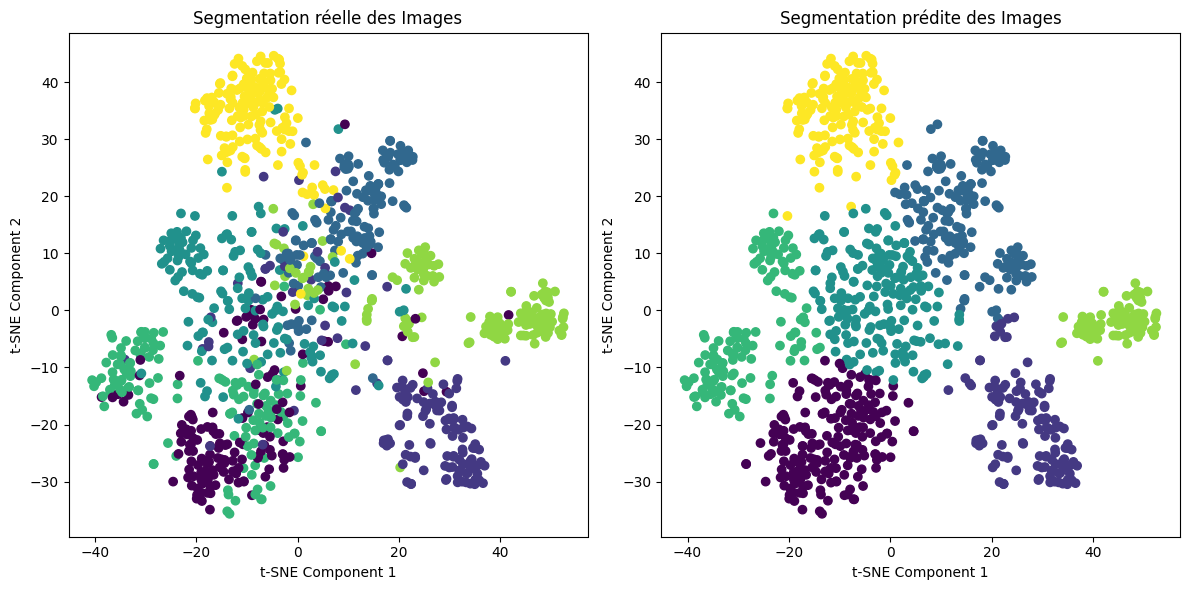

In [18]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_tsne['cluster'], cmap='viridis')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Segmentation réelle des Images')

plt.subplot(1, 2, 2)
plt.scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=cls_labels_transform, cmap='viridis')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Segmentation prédite des Images')

plt.tight_layout()
plt.show()

In [16]:
from sklearn import metrics
ARI = np.round(metrics.adjusted_rand_score(df_tsne['cluster'], cls_labels_transform),4)
ARI

0.4455